# 1. Importing and Data Loading
Author: Tanay Mehta
* LinkedIn: https://www.linkedin.com/in/tanaymehta28/
* Blog: https://tanaymehta.codes
* Website: http://tanaymehta.codes

Note: I am using Dask rather than pandas because it's faster on bigger datasets

In [1]:
! pip install --quiet chart-studio

In [1]:
import numpy as np
import dask as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import fastai
from fastai import *
from fastai.text import *
import os
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
from wordcloud import WordCloud
from plotly.offline import iplot
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'fastai'

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

In [ ]:
data = pd.read_csv("Tweets.csv")
data.head()

# 2. EDA and Data Preprocessing
The Dataset consists of many features, however every features isn't of importance to sentiment classification. There is also a very significant presence of NuLL values in both important and non-important features.
For this, I am just taking 2 features which are the most important ones; `text` and `airline_sentiment` (target)

In [5]:
train_data = data[['airline_sentiment', 'text']]
train_data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [6]:
train_data.info()
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


,airline_sentiment,text
count,14640,14640
unique,3,14427
top,negative,@united thanks
freq,9178,6


### 2.1 Missing Values
As seen below, there aren't any missing values in the dataset

In [7]:
train_data.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

### 2.2 Target Values
Let's now look at the distribution of target values (`airline_sentiment`)

In [8]:
vals = [len(train_data[train_data['airline_sentiment']=='negative']['airline_sentiment']), len(train_data[train_data['airline_sentiment']=='positive']['airline_sentiment']), len(train_data[train_data['airline_sentiment']=='neutral']['airline_sentiment'])]
idx = ['negative', 'positive', 'neutral']
fig = px.pie(
    train_data,
    names='airline_sentiment',
    title='Target Value Distribution Chart',
    height=400,
    width=750
)
iplot(fig)

### 2.3 Character frequency Count
Also, let's count the frequency of characters in the data

In [9]:
neg = train_data[train_data['airline_sentiment']=='negative']['text'].str.len()
pos = train_data[train_data['airline_sentiment']=='positive']['text'].str.len()
neu = train_data[train_data['airline_sentiment']=='neutral']['text'].str.len()

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Histogram(x=list(neg), name='Negative Tweets'),
    row=1, 
    col=1
)

fig.add_trace(
    go.Histogram(x=list(pos), name='Positive Tweets'),
    row=1, 
    col=2,
)

fig.add_trace(
    go.Histogram(x=list(neu), name='Neutral Tweets'),
    row=1, 
    col=3,
)


fig.update_layout(height=400, width=800, title_text="Character Count")
iplot(fig)

### 2.4 Word Count Distribution

In [10]:
neg = train_data[train_data['airline_sentiment']=='negative']['text'].str.split().map(lambda x: len(x))
pos = train_data[train_data['airline_sentiment']=='positive']['text'].str.split().map(lambda x: len(x))
neu = train_data[train_data['airline_sentiment']=='neutral']['text'].str.split().map(lambda x: len(x))

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Histogram(x=list(neg), name='Negative Tweets'),
    row=1, 
    col=1
)

fig.add_trace(
    go.Histogram(x=list(pos), name='Positive Tweets'),
    row=1, 
    col=2,
)

fig.add_trace(
    go.Histogram(x=list(neu), name='Neutral Tweets'),
    row=1, 
    col=3,
)

fig.update_layout(height=500, width=850, title_text="Word Count")
iplot(fig)

### 2.5 Average Word Length Distribution
On an average how many words are present in each set

In [11]:
neg = train_data[train_data['airline_sentiment']=='negative']['text'].str.split().map(lambda x: [len(j) for j in x]).map(lambda x: np.mean(x)).to_list()
pos = train_data[train_data['airline_sentiment']=='positive']['text'].str.split().map(lambda x: [len(j) for j in x]).map(lambda x: np.mean(x)).to_list()
neu = train_data[train_data['airline_sentiment']=='neutral']['text'].str.split().map(lambda x: [len(j) for j in x]).map(lambda x: np.mean(x)).to_list()


fig = ff.create_distplot([neg, pos, neu], ['Negative', 'Positive', 'Neutral'])
fig.update_layout(height=500, width=800, title_text="Average Word Length Distribution")
iplot(fig)

### 2.6 Unqiue Word Count Distribution
How many unique words are in each set

In [12]:
neg = train_data[train_data['airline_sentiment']=='negative']['text'].apply(lambda x: len(set(str(x).split()))).to_list()
pos = train_data[train_data['airline_sentiment']=='positive']['text'].apply(lambda x: len(set(str(x).split()))).to_list()
neu = train_data[train_data['airline_sentiment']=='neutral']['text'].apply(lambda x: len(set(str(x).split()))).to_list()

fig = ff.create_distplot([neg, pos, neu], ['Negative', 'Positive', 'Neutral'])
fig.update_layout(height=500, width=800, title_text="Unique Word Count Distribution")
iplot(fig)

### 2.7 URL Count
How many URLs are present in each tweet

In [13]:
neg = train_data[train_data['airline_sentiment']=='negative']['text'].str.split().map(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w or 'ftp' in w]))
pos = train_data[train_data['airline_sentiment']=='positive']['text'].str.split().map(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w or 'ftp' in w]))
neu = train_data[train_data['airline_sentiment']=='neutral']['text'].str.split().map(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w or 'ftp' in w]))

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
    go.Histogram(x=list(neg), name='Negative Tweets'),
    row=1, 
    col=1
)

fig.add_trace(
    go.Histogram(x=list(pos), name='Positive Tweets'),
    row=1, 
    col=2,
)

fig.add_trace(
    go.Histogram(x=list(neu), name='Neutral Tweets'),
    row=1, 
    col=3,
)

fig.update_layout(height=500, width=850, title_text="URL Count")
iplot(fig)

### 2.8 Word Cloud
Finally, we make a word cloud of the most appearing words in negative, positive and neutral categories

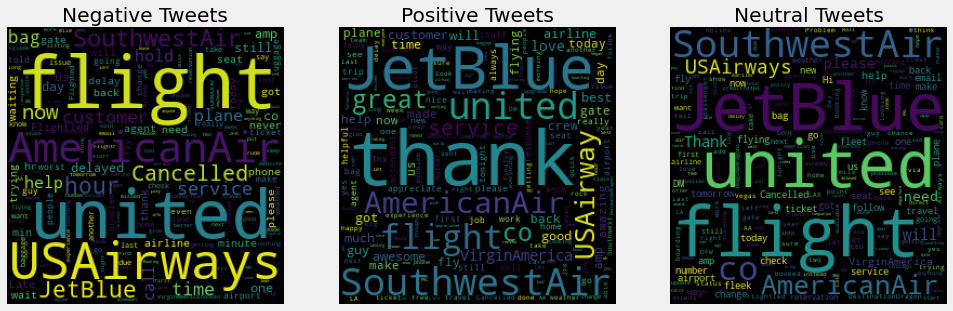

In [14]:
negative = " ".join(train_data[train_data['airline_sentiment'] == 'negative']['text'].to_list())
positive = " ".join(train_data[train_data['airline_sentiment'] == 'positive']['text'].to_list())
neutral = " ".join(train_data[train_data['airline_sentiment'] == 'neutral']['text'].to_list())

fig, ax = plt.subplots(1, 3, figsize=(15,15))
ng_wlc = WordCloud(width=256, height=256, collocations=False).generate(negative)
ps_wlc = WordCloud(width=256, height=256, collocations=False).generate(positive)
ne_wlc = WordCloud(width=256, height=256, collocations=False).generate(neutral)
wcs = [ng_wlc, ps_wlc, ne_wlc]
titls = ["Negative Tweets", "Positive Tweets", "Neutral Tweets"]

for num, el in enumerate(wcs):
    ax[num].imshow(el)
    ax[num].axis('off')
    ax[num].set_title(titls[num])

### 2.9 Cleaning and Tokenizing
Let's just clean the data (by removing the hyperlinks and other unwanted elements

In [15]:
# Get the stopwords
st_wrds = stopwords.words("english")

In [16]:
# Remove everything except basic text characters
train_data['text'] = train_data['text'].str.replace("[^a-zA-Z]", " ").str.lower()
train_data.sample(5)

,airline_sentiment,text
3871,negative,united ua delayed out of winnipeg becaus...
8094,positive,jetblue you guys rock http t co la zaoay
1393,negative,united thanks for having changed me managed ...
5358,negative,southwestair very frustrated saw seats avail...
832,negative,united americanair so that s it it just end...


In [17]:
# Tokenizing the data
tokenized_data = train_data['text'].apply(lambda x: x.split())
tokenized_data = tokenized_data.apply(lambda x: [word for word in x if word not in st_wrds])

In [18]:
tokenized_data.sample(5)

7769     [jetblue, learned, customer, service, sxm, wor...
7119                            [delete, account, jetblue]
12904    [americanair, flew, chi, instead, got, ride, m...
9636     [usairways, point, merger, go, business, turni...
8620     [jetblue, loves, respond, positive, tweets, ig...
Name: text, dtype: object

In [19]:
# Replace the normal text with tokenized text
tok = []
for i in range(len(train_data)):
    t = ' '.join(tokenized_data[i])
    tok.append(t)
train_data['text'] = tok
train_data.sample(5)

,airline_sentiment,text
8028,positive,jetblue thanks reminder older flights taken ea...
9244,positive,usairways good work flight crew chairman recog...
2604,negative,united lax make happen please else cruise lugg...
4789,negative,southwestair cancelled flightled flight resche...
2063,negative,united sure missed mark tonight redeye lax chi...


In [20]:
# Change the column name and encode the labels
train_data = train_data.rename(columns={'airline_sentiment':'label'})
train_data['label'] = train_data['label'].apply(lambda x: 0 if x=='negative' else (1 if x=='positive' else 2))

In [21]:
# Let us now split the dataset into training and validation sets
split_pcent = 0.15  # How much percent of data should go into testing set
split = int(split_pcent * len(train_data))

shuffled_set = train_data.sample(frac=1).reset_index(drop=True)   # Shuffle the data
valid_set = shuffled_set[:split]   # Get everything till split number
train_set = shuffled_set[split:]   # Get everything after split number

In [22]:
# Make a Language Model Data Bunch from our train set
data_bunch = TextLMDataBunch.from_df(train_df=train_set, valid_df=valid_set, path="")

In [23]:
# Make the data classifier
data_clf = TextClasDataBunch.from_df(path="", train_df=train_set, valid_df=valid_set, vocab=data_bunch.train_ds.vocab, bs=16)

# 3. Training the Model
### 3.1 Vanilla Training
Let's first train the model out of the box (we'll get the learning rate and then fit the model for 2 epochs using that learning rate). Although, it won't perform well.

In [24]:
# Define the language learner model and fit for one epoch
learner = language_model_learner(data_bunch, arch=AWD_LSTM, drop_mult=0.5)

learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,7.178286,6.028823,0.136644,02:47


### 3.2 Unfreezing Layers
Till now, the internal layers were not training as they were freezed. Let's now train our model by un-freezing layer after layer.

In [25]:
# Try unfreezing last 3 layers first
layers_to_unfreeze = [1, 2, 3]
for i in layers_to_unfreeze:
    learner.freeze_to(-i)
    learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.988922,5.587568,0.159412,02:46


epoch,train_loss,valid_loss,accuracy,time
0,5.758906,5.478499,0.172210,02:52


epoch,train_loss,valid_loss,accuracy,time
0,5.464791,5.304992,0.181548,03:39


In [26]:
# Now let's unfreeze all layers and train them
learner.unfreeze()
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.237823,5.243339,0.187351,03:47


In [27]:
learner.save_encoder('learn_encoder')

### 3.3 Training the Classifier
Let's just now train the classifier using the encoder we trained on the data.

In [28]:
clf = text_classifier_learner(data_clf, arch=AWD_LSTM, drop_mult=0.5)
clf.load_encoder('learn_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12444 items)
x: TextList
xxbos jetblue xxunk hi know xxunk xxunk mom might like xxunk em contact xxunk http co xxunk,xxbos southwestair thanks sending kid destinationdragons concert vegas imaginedragons awesome http co g b e xxunk,xxbos southwestair still know skis can not get call back bag svc airport left several msgs,xxbos jetblue usually make flight booking problems time teach yea going least haha,xxbos united sure however ticket included one checked bag therefore charge extra completely unanticipated
y: CategoryList
2,1,0,2,0
Path: .;

Valid: LabelList (2196 items)
x: TextList
xxbos united note traveling w yr old unreal,xxbos united thanks,xxbos americanair need apology need fix competent manner,xxbos united ok thanks xxunk located late flight open,xxbos united hours late flightr transit total twelve hours please change plane flight ridiculous sfo
y: CategoryList
0,2,0,2,0
Path: .;

Test: None, model=SequentialRNN(
  (0): Multi

In [29]:
clf.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.656298,0.594410,0.749089,03:21


In [30]:
# Let's unfreeze all it's layers and train it.
clf.unfreeze()
clf.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.614425,0.563955,0.772313,08:51


### 3.3 Discriminative Fine Tuning
Since the AWD_LSTM architecture consists of 3-Stacked LSTMs, the level of information captured by every layer will be more and more complex the deeper we go.
For this, it makes sense to use different learning rates for different layers.
So, Let us try discriminative fine tuning by un-freezing and fine tuning with custom learning rates

In [31]:
# Unfreeze last layer and give it a learning rate range using `slice()` function
# This way it'll use the learning rates from 5e-3/2->5e-3 (i.e: 0.0025 -> 0.005)
clf.freeze_to(-1)
clf.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.582440,0.532288,0.783698,03:26


In [32]:
# No let's unfreeze all the layers and try DFT again
clf.unfreeze()
clf.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.548586,0.523889,0.789162,09:00


# 4. Testing and Conclusion
After all the different learning rates and methods we used, the best accuracy we got was `0.811`.
Let's try and predict a few sentences using the classifier we trained.

Keep in mind about the labels and we encoded them in Data Preprocessing.
* 0 = Negative
* 1 = Positive
* 2 = Neutral

In [33]:
# The Classifier classifies it Neutral, which is right
clf.predict("Hello, how are you doing?")

(Category tensor(2), tensor(2), tensor([0.0748, 0.3889, 0.5362]))

In [34]:
# The Classifier classifier it Negative, which is right
clf.predict("Wow, the flight duration was boring and the passenger treatement was not the best I have seen!")

(Category tensor(1), tensor(1), tensor([0.4067, 0.4807, 0.1126]))

In [35]:
# The Classifier classifier it Positive, which is right
clf.predict("Great service and good staff, I would recommend it!")

(Category tensor(1), tensor(1), tensor([0.2542, 0.6226, 0.1232]))

#### Improvements
* Since the data is a bit imbalanced, Accuracy won't be the best bet in the long run. We could also use Precision, Recall and F1 Score.
* Further exploration of Discriminative Fine Tuning would be surely helpful to obtain better results.
* Better Data Preprocessing (like using Porter-Stemming Algorithm), using other vocab dictionary and better data tokenization techniques will further increase the accuracy.
* Using other models such as BERT, would achieve a better accuracy at classifying tweets.